In [3]:
import pandas as pd
import sys,os,copy,pdb,importlib
sys.path.append('../classes')
sys.path.append('../analysis')
import numpy as np
import matplotlib.pyplot as plt

import tournament_new as tn
import create_database as cd
importlib.reload(cd)

from beck.beck_game import BeckGame as Game
from arena import Arena
importlib.reload(tn)
game = Game(4,9,4)
all_p = pd.read_pickle(cd.DATABASE_LOC)

# res = tn.merge_res_to_base()
tournament_res = pd.read_pickle('/scratch/zz737/fiar/tournaments/ai_all_player_round_robin_base.pkl')

In [4]:
b_str='''0 |- - - X O - O X - |
1 |- - - - X O - - - |
2 |- - - - - O - - - |
3 |- - - - O X X X O |'''

b_arr=game.get_board_from_xo_str(b_str)

In [31]:

p1_id = 'tournament_1;mcts100;cpuct2;best'
# p1_id = 'tournament_1;mcts100;cpuct2;8'
p1_row = cd.select_row_by_id(p1_id,all_p)
p1,p1_val,p1_tree = tn.get_player(game, p1_row, temp=1/10,deterministic=False)

In [32]:
nnet = p1_val

In [122]:
importlib.reload(tn)
import beck
import beck.beck_game
importlib.reload(beck.beck_game)
from beck.beck_game import BeckGame as Game
game=Game(4,9,4)

In [30]:
cog_mcts_row = cd.merge_cog_with_mcts(all_p,'cog_id_1',p1_id)
pcog,pcog_val,_ = tn.get_player(game, cog_mcts_row, temp=1/10,deterministic=False)

NameError: name 'p1_id' is not defined

In [52]:
def policy_val_correlation(canonicalBoard, game, nnet, flip_val=False):
    valids = game.getValidMoves(canonicalBoard, 1)
    a_batch = np.nonzero(valids)[0] # the indices of valid actions
    x_l = a_batch // game.n
    y_l = a_batch % game.n
    n_valids = len(x_l)
    ind_l = np.arange(n_valids)
    board_batch = np.tile(canonicalBoard,(n_valids,1,1)) # vectorized way of getting a batch for evaluation; canonicalBoard, from self's perspective
    if flip_val:
        board_batch = -board_batch
        board_batch[ind_l, x_l, y_l] = -1
        _,val_batch=nnet.predict_batch(board_batch)
        val_batch = -val_batch
    else:
        board_batch[ind_l, x_l, y_l] = 1
        _,val_batch=nnet.predict_batch(board_batch)
        
    policy,_ = nnet.predict(canonicalBoard)
    policy = policy[valids.astype(bool)]
    
    corr = np.corrcoef(val_batch.squeeze(),policy)[0,1]
    return corr
    

In [103]:
cb_b = b_arr[None,:,:]
cb_b

array([[[ 0,  0,  0, -1,  1,  0,  1, -1,  0],
        [ 0,  0,  0,  0, -1,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  1, -1, -1, -1,  1]]])

In [126]:
sys.path.append('../analysis')
import value_analysis as va
opt_boards, opt_values=va.load_opt_value_test_boards()

In [150]:
cb_b = opt_boards[:10]

a_batch = np.arange(game.getActionSize())
x_l = a_batch // game.n
y_l = a_batch % game.n
ind_l = np.arange(len(a_batch))

cb_b_b = np.tile(cb_b[:,None,:,:],(1,len(a_batch),1,1)) #  b x 36 x 4 x 9
cb_b_b[:,ind_l,x_l,y_l] = cb_b_b[:,ind_l,x_l,y_l] + 1 * (cb_b_b[:,ind_l,x_l,y_l]==0).astype(int)

policy_b,_=nnet.predict_batch(cb_b)

_,val_b_batch=nnet.predict_batch(cb_b_b.reshape(-1,4,9))

valids_b=game.getValidMovesBatch(cb_b,1)
valids_b = valids_b.flatten()

policy_b = policy_b.flatten()[valids_b]
val_b_batch = val_b_batch.flatten()[valids_b]

In [151]:
np.corrcoef(policy_b, val_b_batch)[0,1]
            

0.13267929611336746

In [50]:
def policy_val_correlation_batch(canonicalBoard_b, game, nnet, flip_val=False):
#     valids = game.getValidMoves(canonicalBoard, 1)
    a_batch = np.nonzero(valids)[0] # the indices of valid actions
    x_l = a_batch // game.n
    y_l = a_batch % game.n
    n_valids = len(x_l)
    ind_l = np.arange(n_valids)
    board_batch = np.tile(canonicalBoard,(n_valids,1,1)) # vectorized way of getting a batch for evaluation; canonicalBoard, from self's perspective
    if flip_val:
        board_batch = -board_batch
        board_batch[ind_l, x_l, y_l] = -1
        _,val_batch=nnet.predict_batch(board_batch)
        val_batch = -val_batch
    else:
        board_batch[ind_l, x_l, y_l] = 1
        _,val_batch=nnet.predict_batch(board_batch)
        
    policy,_ = nnet.predict(canonicalBoard)
    policy = policy[valids.astype(bool)]
    
    corr = np.corrcoef(val_batch.squeeze(),policy)[0,1]
    return corr
    

In [53]:
game=Game(4,9,4)
corr = policy_val_correlation(b_arr,game,p1_val,flip_val=False)

In [54]:
corr

0.02387067919234863

In [27]:
sys.path.append('../analysis')
import value_analysis as va
opt_boards, opt_values=va.load_opt_value_test_boards()

In [152]:
N_opt_boards = len(opt_boards)
n_boards= 100
# inds = np.random.choice(np.arange(N_opt_boards),n_boards)
inds=range(10)
corr_l = []
for i in inds:
    cb = opt_boards[i]
    corr = policy_val_correlation(cb,game,p1_val,flip_val=False)
    corr_l.append(corr)

In [155]:
np.median(corr_l)

0.21805170730199808

In [31]:
np.random.choice(np.arange(N_opt_boards),3)

array([ 113, 4576, 1358])

In [77]:

canonicalBoard = b_arr
valids = game.getValidMoves(canonicalBoard, 1)
# self.Vs[s] = valids
a_batch = np.nonzero(valids)[0] # the indices of valid actions
x_l = a_batch // game.n
y_l = a_batch % game.n
n_valids = len(x_l)
ind_l = np.arange(n_valids)
board_batch = np.tile(canonicalBoard,(n_valids,1,1)) # vectorized way of getting a batch for evaluation; canonicalBoard, from self's perspective
board_batch[ind_l, x_l, y_l] = 1 # from self perspective

In [78]:
policy = p1_val.predict(b_arr)[0]
policy = policy[valids.astype(bool)]

In [79]:
_,val_batch=p1_val.predict_batch(board_batch)

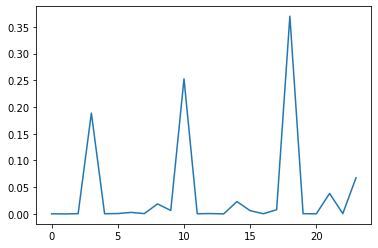

In [58]:
plt.plot(policy)

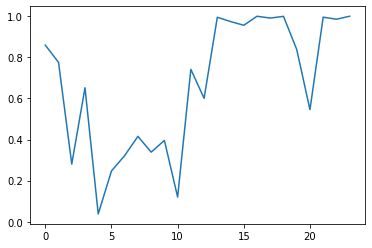

In [59]:
plt.plot(val_batch)

In [52]:
np.corrcoef(val_batch.squeeze(),policy)

array([[ 1.        , -0.47602053],
       [-0.47602053,  1.        ]])

In [16]:
_,val_batch = pcog_val.predict_batch(board_batch)
np.corrcoef(val_batch.squeeze(),policy)

array([[1.        , 0.07432317],
       [0.07432317, 1.        ]])

In [80]:
p1_tree.refresh()

In [81]:
for _ in range(100):
    p1_tree.search(b_arr)

In [82]:
canonicalBoard = b_arr
self=p1_tree
s = self.game.stringRepresentation(canonicalBoard)
counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]
counts=np.array(counts)

In [85]:
p1_tree.getActionProb(b_arr,temp=0)

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [84]:
counts

array([ 0,  0,  0,  0,  0, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0, 28,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 29,  0,  0,  0,  0,  9,  0,  0,  0,
        0,  0])

In [83]:
np.corrcoef(counts[valids.astype(bool)],policy)

array([[1.   , 0.479],
       [0.479, 1.   ]])

In [75]:
np.set_printoptions(suppress=True,precision=3)
policy

array([0.   , 0.   , 0.001, 0.189, 0.   , 0.001, 0.003, 0.001, 0.019,
       0.007, 0.253, 0.   , 0.001, 0.   , 0.023, 0.006, 0.   , 0.008,
       0.37 , 0.001, 0.   , 0.038, 0.001, 0.068], dtype=float32)

In [43]:
len(p1_tree.Qsa.keys())

3

In [44]:
tree = p1_tree
Npieces = {}
for k in tree.Es.keys():
    k_board = np.frombuffer(k,dtype=int)
    Npieces[k] = np.sum(k_board!=0)

In [45]:
Npieces.values()

dict_values([12, 13, 13, 14])

In [46]:
tree.Ns

{b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\

In [161]:
importlib.reload(va)

<module 'value_analysis' from '../analysis/value_analysis.py'>

In [162]:
import time
beg=time.time()
pv_corr_res=va.policy_val_correlation_all_board_one_model(opt_boards,game,nnet,flip_val=False)
duration=time.time() - beg
print(duration)

policy value corr:   5%|▌         | 172/3249 [00:11<03:26, 14.90it/s]/ext3/miniconda3/envs/fourinarow/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/ext3/miniconda3/envs/fourinarow/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
policy value corr: 100%|██████████| 3249/3249 [03:38<00:00, 14.88it/s]

218.32545256614685


/ext3/miniconda3/envs/fourinarow/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/ext3/miniconda3/envs/fourinarow/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([   8.,   15.,   25.,   95.,  361., 1342.,  799.,  386.,  144.,
          53.]),
 array([-0.95054509, -0.75549081, -0.56043653, -0.36538225, -0.17032797,
         0.02472632,  0.2197806 ,  0.41483488,  0.60988916,  0.80494344,
         0.99999773]),
 <BarContainer object of 10 artists>)

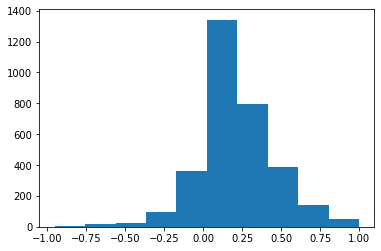

In [165]:
plt.hist(pv_corr_res['pv_corr'])

In [168]:
import compute_depth_parallel as cdp

In [169]:
pvcorr_res=cdp.read_depth_entropy_result(to_read='pvcorr')

In [171]:
pvcorr_res.sort_values('iter')

,pvcorr,npieces,iter
3248,0.493339,24,1
1087,-0.040424,18,1
1086,0.371474,17,1
1085,-0.066569,16,1
1084,-0.291780,15,1
...,...,...,...
1086,-0.006850,17,39
1087,0.373268,18,39
1088,0.257280,6,39
1078,0.423844,9,39


<AxesSubplot:xlabel='iter', ylabel='pvcorr'>

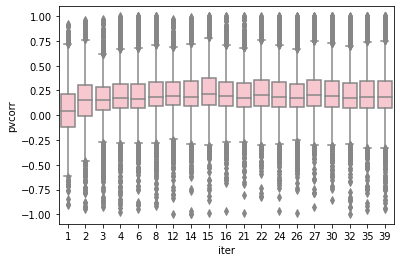

In [175]:
import seaborn as sns
sns.boxplot(x='iter',y='pvcorr',data=pvcorr_res,color='pink')

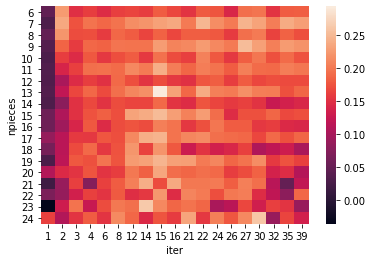

In [173]:
pvcorr_median_grouped = pvcorr_res.groupby(['npieces','iter'])['pvcorr'].median()
pvcorr_median_grouped = pvcorr_median_grouped.unstack()
fig=sns.heatmap(data=pvcorr_median_grouped).figure

In [176]:
depth_res = cdp.read_depth_entropy_result(to_read='depth')

In [ ]:
func = 

In [199]:
def corr_two_gpb(df1,gpb2,key1,key2):
    return np.corrcoef(df1[key1],gpb2.get_group(df1['iter'].iloc[0])[key2])[0,1]

df1=depth_res.groupby('iter').get_group(1)

In [200]:
corr_two_gpb(df1,pvcorr_res.groupby('iter'),'depth_ratio','pvcorr')

nan

In [197]:
pd.concat([depth_res.groupby('iter'),pvcorr_res.groupby('iter')],axis=1)

TypeError: cannot concatenate object of type '<class 'pandas.core.groupby.generic.DataFrameGroupBy'>'; only Series and DataFrame objs are valid

In [201]:
depth_res.shape

(61731, 4)

In [206]:
pvcorr_res.shape

(61731, 3)